<a href="https://colab.research.google.com/github/Wairioko/Kenya-Coffee/blob/main/Kenya_Coffee_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display
# from statsmodels.tsa.stattools import adfuller
import plotly.graph_objs as go
# from matplotlib.ticker import ScalarFormatter
import plotly.offline as pyo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from sklearn.cluster import KMeans
# from sklearn.linear_model import LinearRegression

In [36]:
#get data
world_consump = pd.read_csv('/content/Coffee_importers_consumption.csv')
world_prod = pd.read_csv('/content/Coffee_production.csv')

# get kenya production data
kenya_prod = world_prod.loc[world_prod['Country']=='Kenya']

# convert year columns for ease in analysis
# Create a function to rename the columns
def rename_columns(df):
    column_mapping = {}
    for column_name in df.columns:
        if '/' in column_name:
            start_year = int(column_name[:4])
            new_column_name = str(start_year)
        else:
            new_column_name = column_name
        column_mapping[column_name] = new_column_name
    df = df.rename(columns=column_mapping)
    return df

# call function with data you want cleaned
local_prod = rename_columns(kenya_prod)

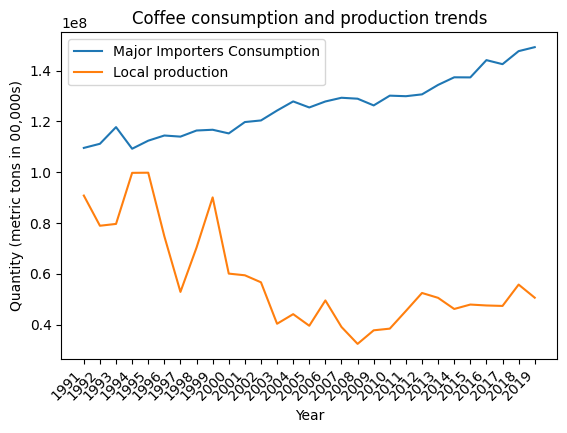

In [37]:
# Calculate mean column-wise for a DataFrame
world_consump = world_consump.select_dtypes(include='number').mean()

# Create a new DataFrame with one row for mean values
world_consump = pd.DataFrame(world_consump).transpose()
world_consump.reindex = ['world_consumption']

# drop columns not needed for plotting trend analysis
local_prod = local_prod.drop('Coffee type', axis=1)
local_prod = local_prod.drop('Country', axis=1)
local_prod = local_prod.drop('Total_production', axis=1)
world_consump = world_consump.drop(['Total_import_consumption'], axis=1)


# Create line plots to show trends over time period 1991-2019
plt.plot(world_consump.columns[1:], world_consump.iloc[0, 1:], 
         label='Major Importers Consumption')
plt.plot(local_prod.columns[1:].tolist(), local_prod.iloc[0, 1:].tolist(), 
         label='Local production')

plt.xlabel('Year')
plt.ylabel('Quantity (metric tons in 00,000s)')
plt.title('Coffee consumption and production trends')
plt.legend()
plt.gca().autoscale
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)
plt.show()

The highest quality ratio of 0.9999888102706795 was found in Narok South  Society  in Narok  county.
Number of outliers found: 172
              County  Count
9            Kiambu     527
25      Trans Nzoia     225
17         Murang'a     129
13         Machakos     129
8           Kericho     118
23            Nyeri      82
5              Embu      74
20            Nandi      73
10        Kirinyaga      71
26      Uasin Gishu      63
24    Tharaka Nithi      60
2           Bungoma      58
19           Nakuru      50
11            Kisii      49
15             Meru      37
0           Baringo      24
22          Nyamira      21
4   Elgeyo Marakwet      17
1             Bomet      14
16           Migori      12
14          Makueni       9
12           Kisumu       7
7          Kakamega       6
6           Homabay       6
18          Nairobi       3
27       West Pokot       3
21            Narok       2
3             Busia       1


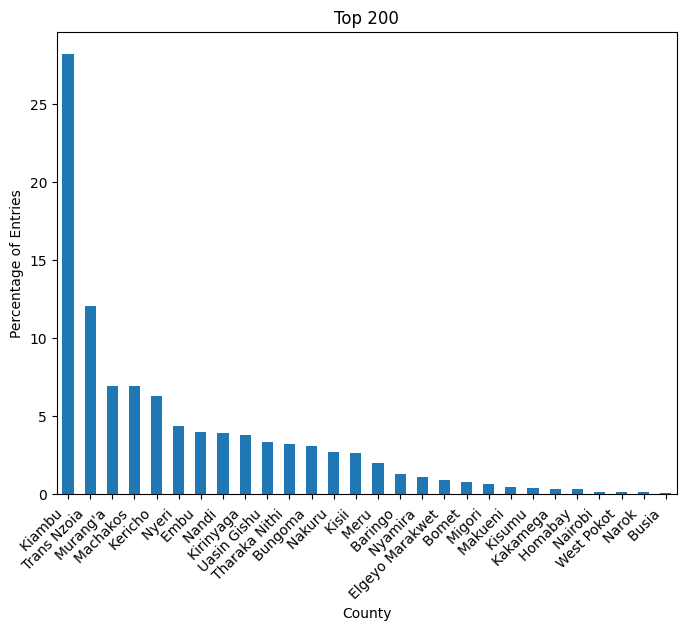

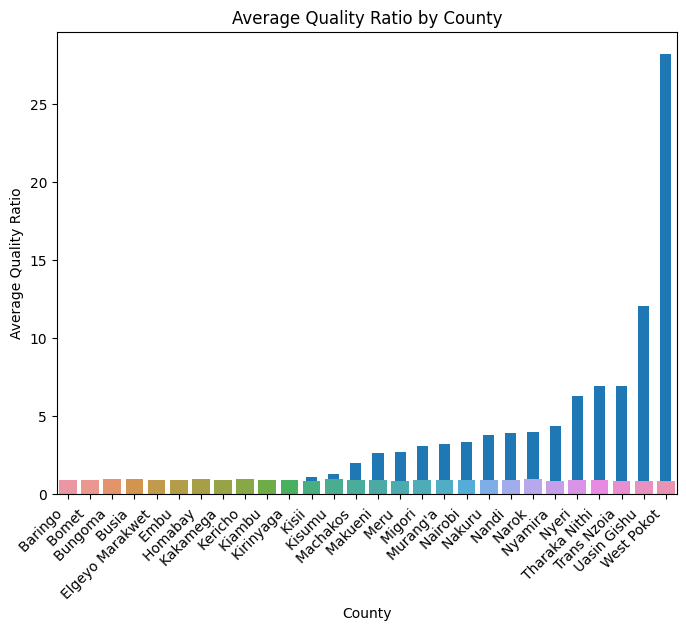

In [38]:
# calculate efficiency by society by county
# load data
coffee_quality = pd.read_csv("/content/clean_production21.csv")

def clean(data):
  # Drop rows with missing values in either the 'Total cherry' or 'Total buni' columns
  data.dropna(subset=['Clean', 'Buni'], inplace=True)
  # clean our columns by converting them to ints only
  data['Clean'] = data['Clean'].str.replace('[,.]', '', regex=True).str.replace('\D', '', regex=True)
  data['Clean'] = data['Clean'].apply(lambda x: int(x) if x else 0)
  # do same for buni column
  data['Buni'] = data['Buni'].str.replace('[,.]', '', regex=True).str.replace('\D', '', regex=True)
  data['Buni'] = data['Buni'].apply(lambda x: int(x) if x else 0)
  # drop any data with value 0
  data = data.drop(data[(data['Clean'] == 0) | (data['Buni'] == 0)].index)
  return data
 
cleaned_data = clean(coffee_quality)

def quality_ratio(data):
  # calculate the "quality ratio" to show how efficient a society is
  data['quality_ratio'] = data['Clean'] / (data["Clean"]+data['Buni'])
  # Find the index label of the row with the highest quality ratio
  max_ratio_index = data['quality_ratio'].idxmax()
  # Get the details from other columns using the loc[] accessor
  max_ratio_details = data.loc[max_ratio_index, ['County', 'Sector', 'Grower', 'quality_ratio']]
  # Print out the details
  print(f"The highest quality ratio of {max_ratio_details['quality_ratio']} was found in {max_ratio_details['Grower']} {max_ratio_details['Sector']} in {max_ratio_details['County']} county.")
  # arrange data in descending order according to out quality ratio column
  data = data.sort_values(by='quality_ratio', ascending=False)
  data.to_csv("quality_ratio.csv")
  return data

quality_ratio_data = quality_ratio(cleaned_data)

def remove_outlier(data):
  # Calculate the IQR of the quality_ratio column
  q1 = data['quality_ratio'].quantile(0.25)
  q3 = data['quality_ratio'].quantile(0.75)
  iqr = q3 - q1

  # Define the upper and lower bounds for outliers
  upper_bound = q3 + 1.5 * iqr
  lower_bound = q1 - 1.5 * iqr

  # Identify outliers in the quality_ratio column
  outliers = data[(data['quality_ratio'] > upper_bound) | (data['quality_ratio'] < lower_bound)]

  # Remove outliers from the data
  data = data[(data['quality_ratio'] <= upper_bound) & (data['quality_ratio'] >= lower_bound)]
  # Print the number of outliers found
  print(f"Number of outliers found: {len(outliers)}")
  
  return data

outlier_cleaned_data = remove_outlier(quality_ratio_data)
# Define function to plot top or bottom entries by county
def plot_entries_by_county(data, n, is_top=True):
    # Calculate summary statistics
    summary = data.groupby('County').agg({'Clean': 'sum', 'Buni': 'sum', 'quality_ratio': ['count', 'mean']})
    summary.columns = ['Clean_sum', 'Buni_sum', 'Count', 'Quality_ratio_mean']
    summary = summary.sort_values('Count', ascending=not is_top)[:n]

    # Calculate percentage of entries by county
    summary['Percentage'] = summary['Count'] / summary['Count'].sum() * 100

    # Plot bar chart of percentage of entries per county
    plt.figure(figsize=(8, 6))
    ax = summary['Percentage'].plot(kind='bar')
    ax.set_xticklabels(summary.index, rotation=45, ha='right')
    ax.set_xlabel('County')
    ax.set_ylabel('Percentage of Entries')
    ax.set_title(f'Top {n}' if is_top else f'Bottom {n}')


# Plot top 200 entries by county
top_200 = plot_entries_by_county(outlier_cleaned_data, 200)
# Plot bottom 200 entries by county
bottom_200 = plot_entries_by_county(outlier_cleaned_data, 200, False)

def ratio_by_county(data):
  # Calculate summary statistics
  summary = data.groupby('County').agg({'Clean': 'sum', 'Buni': 'sum', 'quality_ratio': ['count', 'mean']})
  summary.columns = ['Clean_sum', 'Buni_sum', 'Count', 'Quality_ratio_mean']
  summary.reset_index(inplace=True)
  # Print number of entries for each county
  print(summary[['County', 'Count']].sort_values('Count', ascending=False))
  # Create a bar plot of average quality ratio by county
  sns.barplot(data=summary, x='County', y='Quality_ratio_mean')
  # Add axis labels and title
  plt.xlabel('County')
  plt.ylabel('Average Quality Ratio')
  plt.title('Average Quality Ratio by County')
  # Rotate x-axis labels to avoid overlap
  plt.xticks(rotation=45)
  # Show the plot
  plt.show()

ratio_by_county(outlier_cleaned_data)
